## Loading the data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv("Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [3]:
reviews= reviews[['Text', 'Score']]
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [4]:
reviews.dropna()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
568449,Great for sesame chicken..this is a good if no...,5
568450,I'm disappointed with the flavor. The chocolat...,2
568451,"These stars are small, so you can give 10-15 o...",5
568452,These are the BEST treats for training and rew...,5


## Preprocessing

In [5]:
reviews= reviews.drop(reviews[reviews.Score == 3].index)
#shape after removing score==3
reviews.shape

(525814, 2)

In [6]:
#if score> 3, set score = 1
#if score<=2, set score = 0
def set_score(value):
    if value > 3:
        return 1
    else:
        return 0
reviews['Score'] = reviews['Score'].apply(set_score)

In [7]:
reviews.shape

(525814, 2)

In [8]:
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [9]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]

In [10]:
reviews.shape

(234088, 3)

In [11]:
reviews.head()

,Text,Score,len
0,I have bought several of the Vitality canned d...,1,48
1,Product arrived labeled as Jumbo Salted Peanut...,0,31
3,If you are looking for the secret ingredient i...,0,41
4,Great taffy at a great price. There was a wid...,1,27
6,This saltwater taffy had great flavors and was...,1,49


In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
#remove HTML from the Text column and save in the Text column only
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(reviews['Text'].values):
    clean = re.compile('<.*?>')
    sentance=re.sub(clean, '',sentance )
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 234088/234088 [01:17<00:00, 3023.35it/s]


In [14]:
reviews['Text']=preprocessed_reviews

In [15]:
y = reviews['Score'].values
X = reviews.drop(['Score'], axis=1)
X.head()

,Text,len
0,i have bought several of the vitality canned d...,48
1,product arrived labeled as jumbo salted peanut...,31
3,if you are looking for the secret ingredient i...,41
4,great taffy at a great price there was a wide ...,27
6,this saltwater taffy had great flavors and was...,49


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(163861, 2) (163861,)
(70227, 2) (70227,)


## Bag of Words Vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['Text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train['Text'].values)
X_test_bow = vectorizer.transform(X_test['Text'].values)
bow_feature_names= vectorizer.get_feature_names()

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(163861, 5000) (163861,)
(70227, 5000) (70227,)


## TF-IDF Vectorization

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['Text'].values)

X_train_tfidf = vectorizer.transform(X_train['Text'].values)
X_test_tfidf = vectorizer.transform(X_test['Text'].values)
tfidf_feature_names= vectorizer.get_feature_names()

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(163861, 9243) (163861,)
(70227, 9243) (70227,)


## TF-IDF-Word2Vec Vectorization

In [19]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [20]:
tfidf_model = TfidfVectorizer(min_df=10)
tfidf_model.fit(X_train['Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [21]:
def tfidf_word2vec_transform(X,glove_words,tfidf_words):
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(X): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

In [22]:
X_train_tfidf_word2vec = tfidf_word2vec_transform(X_train['Text'].values,glove_words,tfidf_words)
X_test_tfidf_word2vec = tfidf_word2vec_transform(X_test['Text'].values,glove_words,tfidf_words)

print("The after vectorizations")
print("({},{})".format(len(X_train_tfidf_word2vec),len(X_train_tfidf_word2vec[0])))
print("({},{})".format(len(X_test_tfidf_word2vec),len(X_test_tfidf_word2vec[0])))

100%|██████████████████████████████████████████████████████████████████████████| 70227/70227 [00:14<00:00, 4931.61it/s]

The after vectorizations
(163861,300)
(70227,300)


## TF-IDF Modelling

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
model = XGBClassifier(booster='gbtree',n_jobs=-1)

In [46]:
param_grid = {'max_depth':[1, 3, 5, 7]} 
clf = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_bow,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

In [47]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.030541,0.055674,0.582842,0.067581,1,{'max_depth': 1},0.858035,0.851542,0.853099,0.854225,0.002768,4,0.853217,0.856361,0.854659,0.854746,0.001285
1,5.591415,0.153466,0.570490,0.027617,3,{'max_depth': 3},0.917517,0.910530,0.913431,0.913826,0.002866,3,0.915976,0.918945,0.918176,0.917699,0.001258
2,8.644464,0.400240,0.780538,0.224975,5,{'max_depth': 5},0.940602,0.933125,0.936214,0.936647,0.003068,2,0.944778,0.943973,0.944397,0.944383,0.000329
3,13.071626,0.234432,0.941567,0.245374,7,{'max_depth': 7},0.952869,0.946982,0.949997,0.949949,0.002403,1,0.962123,0.961914,0.961940,0.961993,0.000093


In [48]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param = results['param_max_depth']

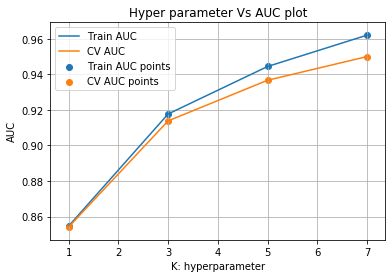

In [49]:
plt.plot(param, train_auc, label='Train AUC')
plt.plot(param, cv_auc, label='CV AUC')
plt.scatter(param, train_auc, label='Train AUC points')
plt.scatter(param, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [50]:
train_auc_list = []
test_auc_list = []

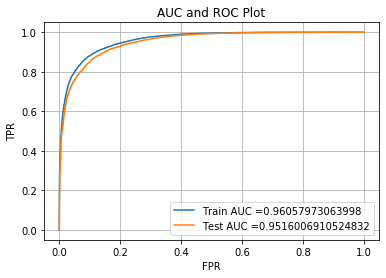

In [51]:
from sklearn.metrics import roc_curve, auc

y_train_bow_pred = clf.predict_proba(X_train_bow)[:,1]
y_test_bow_pred = clf.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_bow_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_bow_pred)

bow_train_auc=auc(train_fpr, train_tpr)
bow_test_auc=auc(test_fpr, test_tpr)

train_auc_list.append(bow_train_auc)
test_auc_list.append(bow_train_auc)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(bow_train_auc))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(bow_test_auc))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC and ROC Plot")
plt.grid()
plt.show()

In [52]:
y_train_predict = clf.predict(X_train_bow)
y_test_predict = clf.predict(X_test_bow)

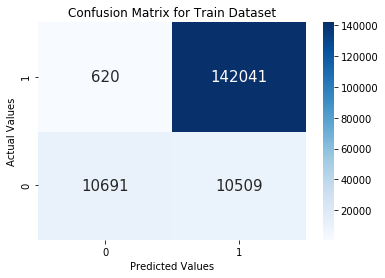

In [53]:
from sklearn.metrics import confusion_matrix

df=confusion_matrix(y_train, y_train_predict)
sns.heatmap(df, annot=True,fmt="g",cmap="Blues", annot_kws={"size": 15})
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim(0,2)
plt.ylim(0,2)
plt.title("Confusion Matrix for Train Dataset") 
plt.show()

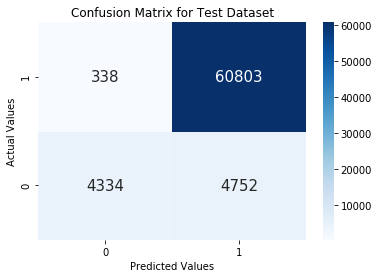

In [54]:
from sklearn.metrics import confusion_matrix

df=confusion_matrix(y_test, y_test_predict)
sns.heatmap(df, annot=True,fmt="g",cmap="Blues", annot_kws={"size": 15})
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim(0,2)
plt.ylim(0,2)
plt.title("Confusion Matrix for Test Dataset") 
plt.show()

In [55]:
from sklearn.metrics import accuracy_score

print("Training Accuracy: ",accuracy_score(y_train,y_train_predict)*100)
print("test accuracy: ",accuracy_score(y_test,y_test_predict)*100)

Training Accuracy:  93.20826798322969
test accuracy:  92.7520754125906


## TF-IDF Modelling

In [56]:
param_grid = {'max_depth':[1, 3, 5, 7]} 
clf = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_tfidf,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

In [57]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.097444,0.043927,0.428079,0.042624,1,{'max_depth': 1},0.858058,0.850248,0.853325,0.853877,0.003212,4,0.854133,0.856344,0.854149,0.854876,0.001039
1,10.328331,0.560676,0.513914,0.025666,3,{'max_depth': 3},0.914175,0.905434,0.908725,0.909445,0.003605,3,0.913803,0.915162,0.914150,0.914372,0.000577
2,20.030519,0.574051,0.596684,0.015911,5,{'max_depth': 5},0.935627,0.927757,0.931037,0.931473,0.003228,2,0.942039,0.942566,0.941781,0.942129,0.000327
3,27.058679,1.851468,0.691464,0.100306,7,{'max_depth': 7},0.948071,0.941186,0.943676,0.944311,0.002847,1,0.961675,0.961691,0.960463,0.961276,0.000575


In [58]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param = results['param_max_depth']

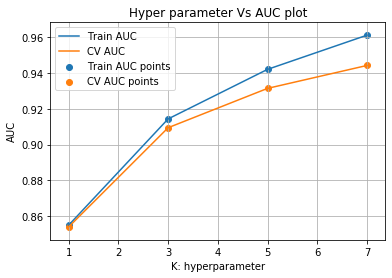

In [59]:
plt.plot(param, train_auc, label='Train AUC')
plt.plot(param, cv_auc, label='CV AUC')
plt.scatter(param, train_auc, label='Train AUC points')
plt.scatter(param, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

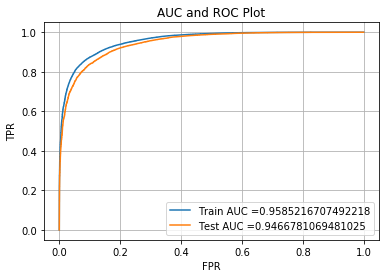

In [60]:
from sklearn.metrics import roc_curve, auc

y_train_tfidf_pred = clf.predict_proba(X_train_tfidf)[:,1]
y_test_tfidf_pred = clf.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_tfidf_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_tfidf_pred)

tfidf_train_auc=auc(train_fpr, train_tpr)
tfidf_test_auc=auc(test_fpr, test_tpr)

train_auc_list.append(tfidf_train_auc)
test_auc_list.append(tfidf_test_auc)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(tfidf_train_auc))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(tfidf_test_auc))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC and ROC Plot")
plt.grid()
plt.show()

In [61]:
y_train_predict = clf.predict(X_train_tfidf)
y_test_predict = clf.predict(X_test_tfidf)

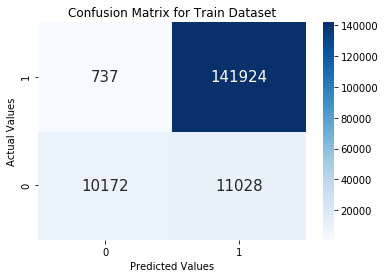

In [62]:
df=confusion_matrix(y_train, y_train_predict)
sns.heatmap(df, annot=True,fmt="g",cmap="Blues", annot_kws={"size": 15})
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim(0,2)
plt.ylim(0,2)
plt.title("Confusion Matrix for Train Dataset") 
plt.show()

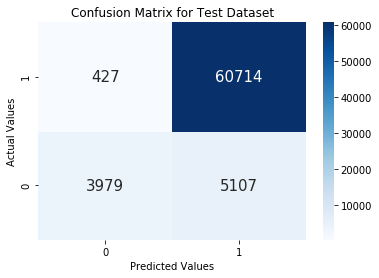

In [63]:
df=confusion_matrix(y_test, y_test_predict)
sns.heatmap(df, annot=True,fmt="g",cmap="Blues", annot_kws={"size": 15})
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim(0,2)
plt.ylim(0,2)
plt.title("Confusion Matrix for Test Dataset") 
plt.show()

In [64]:
from sklearn.metrics import accuracy_score

print("Training Score: ",accuracy_score(y_train,y_train_predict)*100)
print("test accuracy: ",accuracy_score(y_test,y_test_predict)*100)

Training Score:  92.82013413808045
test accuracy:  92.1198399475985


## TF-IDF-Word2Vec Modelling

In [65]:
X_train_tfidf_word2vec = np.array(X_train_tfidf_word2vec)
X_test_tfidf_word2vec = np.array(X_test_tfidf_word2vec)

In [66]:
X_train_tfidf_word2vec.shape

(163861, 300)

In [67]:
param_grid = {'max_depth':[1, 3, 5, 7]} 
clf = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_tfidf_word2vec,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

In [68]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,21.850757,0.757025,0.175855,0.027197,1,{'max_depth': 1},0.836457,0.822340,0.837120,0.831973,0.006817,4,0.835399,0.838561,0.836331,0.836764,0.001327
1,61.472384,1.817862,0.175453,0.020462,3,{'max_depth': 3},0.894881,0.886675,0.896304,0.892620,0.004244,3,0.904116,0.907899,0.906009,0.906008,0.001544
2,100.403451,2.051467,0.201420,0.015576,5,{'max_depth': 5},0.923436,0.916650,0.922933,0.921006,0.003087,2,0.950912,0.952882,0.952187,0.951994,0.000816
3,139.559245,4.769630,0.245964,0.025122,7,{'max_depth': 7},0.942792,0.937143,0.942246,0.940727,0.002544,1,0.989784,0.990257,0.990605,0.990215,0.000336


In [69]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score']
cv_auc_std= results['std_test_score']
param = results['param_max_depth']

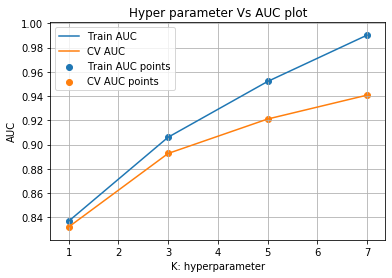

In [70]:
plt.plot(param, train_auc, label='Train AUC')
plt.plot(param, cv_auc, label='CV AUC')
plt.scatter(param, train_auc, label='Train AUC points')
plt.scatter(param, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

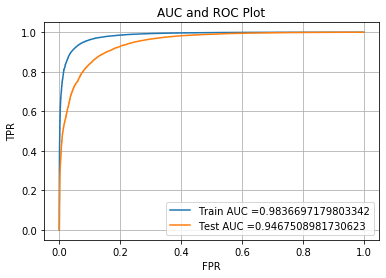

In [71]:
from sklearn.metrics import roc_curve, auc

y_train_tfidf_word2vec_pred = clf.predict_proba(X_train_tfidf_word2vec)[:,1]
y_test_tfidf_word2vec_pred = clf.predict_proba(X_test_tfidf_word2vec)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_tfidf_word2vec_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_tfidf_word2vec_pred)

tfidf_word2vec_train_auc=auc(train_fpr, train_tpr)
tfidf_word2vec_test_auc=auc(test_fpr, test_tpr)

train_auc_list.append(tfidf_word2vec_train_auc)
test_auc_list.append(tfidf_word2vec_test_auc)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(tfidf_word2vec_train_auc))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(tfidf_word2vec_test_auc))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC and ROC Plot")
plt.grid()
plt.show()

In [72]:
y_train_predict = clf.predict(X_train_tfidf_word2vec)
y_test_predict = clf.predict(X_test_tfidf_word2vec)

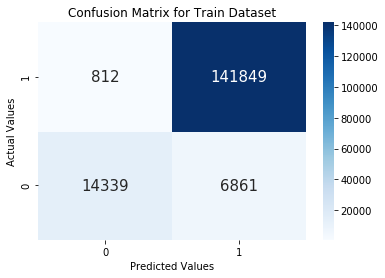

In [73]:
df=confusion_matrix(y_train, y_train_predict)
sns.heatmap(df, annot=True,fmt="g",cmap="Blues", annot_kws={"size": 15})
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim(0,2)
plt.ylim(0,2)
plt.title("Confusion Matrix for Train Dataset") 
plt.show()

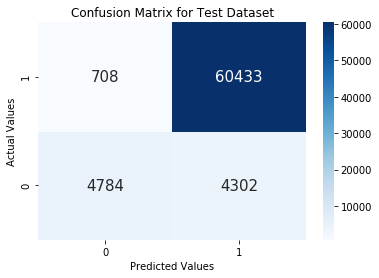

In [74]:
df=confusion_matrix(y_test, y_test_predict)
sns.heatmap(df, annot=True,fmt="g",cmap="Blues", annot_kws={"size": 15})
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim(0,2)
plt.ylim(0,2)
plt.title("Confusion Matrix for Test Dataset") 
plt.show()

In [75]:
from sklearn.metrics import accuracy_score

print("Training Score: ",accuracy_score(y_train,y_train_predict)*100)
print("test accuracy: ",accuracy_score(y_test,y_test_predict)*100)

Training Score:  95.31737265121048
test accuracy:  92.86599171258918


## Summary of Results

In [76]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorisor", "Model", "Train AUC Score", "Test AUC Score"]

x.add_row(["Bag of Words","XGBoost-GBDT",np.round(train_auc_list[0],4),np.round(test_auc_list[0],4)])
x.add_row(["TF-IDF","XGBoost-GBDT",np.round(train_auc_list[1],4),np.round(test_auc_list[1],4)])
x.add_row(["TF-IDF_Weighted Word2vec","XGBoost-GBDT",np.round(train_auc_list[2],4),np.round(test_auc_list[2],4)])


In [77]:
print(x)

+--------------------------+--------------+-----------------+----------------+
|        Vectorisor        |    Model     | Train AUC Score | Test AUC Score |
+--------------------------+--------------+-----------------+----------------+
|       Bag of Words       | XGBoost-GBDT |      0.9606     |     0.9606     |
|          TF-IDF          | XGBoost-GBDT |      0.9585     |     0.9467     |
| TF-IDF_Weighted Word2vec | XGBoost-GBDT |      0.9837     |     0.9468     |
+--------------------------+--------------+-----------------+----------------+
